In [1]:
import pandas as pd
pd.set_option("display.max_columns",999)
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
fpos = np.array(open('/Users/Max/Dropbox/Clostridium_paper/RNA-seq_wig_files/CO1_RNA-seq_RPM.pos.wig').read().split('\n')[2:-1])
fneg = np.array(open('/Users/Max/Dropbox/Clostridium_paper/RNA-seq_wig_files/CO1_RNA-seq_RPM.neg.wig').read().split('\n')[2:-1])
# .read() reads file, which is split into lines by split('\n')
# Only 3rd to last lines are read (using the specification [2:-1]) to avoid importing the header text
# -1 ensures there's no space left at the end
# numpy puts these strings into an array
fpos = fpos.astype(np.float)
fneg = fneg.astype(np.float)
fneg= np.abs(fneg)
# the elements of the array read from the file are converted to floats so operations can be performed on them

In [3]:
infile = SeqIO.read('/home/m/genome_files/REF-seq_CLJU.gbk','gb')
genes =[]
name = []
product = []
func = []
strand = []
start = []
stop = []
aaseq = []
cds_seq = []

    #genome_seq_df = pd.DataFrame({'sequence':list(str(infile.seq))},index=range(1,len(str(infile.seq))+1))
for feature in infile.features:
    if feature.type == 'CDS' and 'product' in feature.qualifiers:  #Only cares for coding sequences which are not pseudogenes
        genes.append(feature.qualifiers['locus_tag'][0])
        try: name.append(feature.qualifiers['gene'][0])
        except: name.append('')
        product.append(feature.qualifiers['product'][0])
        cds_seq.append(feature.location.extract(infile.seq).tostring())
        if 'function' in feature.qualifiers:                       #not all genes have known functions
            func.append(feature.qualifiers['function'][0])
        else:
            func.append("N/A")
        try:
            aaseq.append(feature.qualifiers['translation'][0])
        except:
            aaseq.append("N/A")
        if feature.strand == 1:
            strand.append("plus")
            start.append(feature.location.start.real+1)
            stop.append(feature.location.end.real)
        elif feature.strand == -1:
            strand.append("minus")
            start.append(feature.location.start.real+1)
            stop.append(feature.location.end.real)
gene_df = pd.DataFrame({"gene_id": genes, "name": name, "product": product, "function": func, "strand": strand, "start": start, "stop": stop, "cds_seq":cds_seq,"aaseq": aaseq},
                          columns = ["gene_id", "name", "function", "product", "strand", "start", "stop", "cds_seq","aaseq"])



/home/m/anaconda2/lib/python2.7/site-packages/Bio/Seq.py:341: BiopythonDeprecationWarning: This method is obsolete; please use str(my_seq) instead of my_seq.tostring().
  BiopythonDeprecationWarning)


# Calculation of antisense RNA
1. for genes on plus strand, antisense = minus strand coverage/plus strand coverage
2. for genes on minus strand, antisense = plus strand coverage/minus starnd coverage

In [20]:
minus = []
plus = []
antisense=[]
for index, row in gene_df.iterrows():
    pp = fpos[(row['start']):(row['stop'])+1].sum()
    plus.append(pp)
    mm = fneg[(row['start']):(row['stop'])+1].sum()
    minus.append(mm)
    if row['strand']=='plus':
        aa = (mm+0.001)/(pp+1.0)
        antisense.append(aa)
    elif row['strand']=='minus':
        aa = (pp+0.001)/(mm+1.0)
        antisense.append(aa)
gene_df.loc[:,'wig_plus']=plus
gene_df.loc[:,'wig_minus']=minus
gene_df.loc[:,'antisense']=antisense

In [62]:
gene_df.columns.values

array(['gene_id', 'name', 'function', 'product', 'strand', 'start', 'stop',
       'cds_seq', 'aaseq', 'wig_plus', 'wig_minus', 'antisense',
       'prime_cov', 'middle_cov', '3prime_cov', 'Fprime_cov', 'Tprime_cov',
       'Fprime_ratio', 'Tprime_ratio'], dtype=object)

In [21]:
df = pd.read_excel('/Users/Max/Dropbox/collaboration_with_sam_ernesto/all_omics_combined.xls')

In [22]:
df.columns.values

array([u'Protein IDs', u'Peptides CO_anaerobic_1',
       u'Sequence coverage [%]', u'Mol. weight [kDa]', u'Sequence length',
       u'Q-value', u'Score', u'CO_1', u'CO_2', u'CO_3', u'Fructose_1',
       u'Fructose_2', u'Fructose_3', u'Ttest', u'CO_1.1', u'CO_2.1',
       u'CO_3.1', u'Fructose_1.1', u'Fructose_2.1', u'Fructose_3.1',
       u'gene_id', u'translation_CO1', u'translation_CO2',
       u'translation_HF1', u'translation_HF2', u'name', u'function',
       u'product', u'strand', u'start', u'stop', u'cds_seq', u'aaseq',
       u'CO_trans_ave', u'HF_trans_ave', u'co1RnaFPKM', u'co2RnaFPKM',
       u'hf1RnaFPKM', u'hf2RnaFPKM', u'RNA_ave_CO', u'RNA_ave_HF',
       u'co_trans_eff', u'hf_trans_eff', u'percent_translation_co',
       u'percent_translation_hf'], dtype=object)

In [23]:
ff=gene_df[['gene_id', 'antisense']]
df1 = pd.merge(df,ff)

In [24]:
df2=df1[(df1.HF_trans_ave >1.0) & (df1.CO_trans_ave >1.0)]

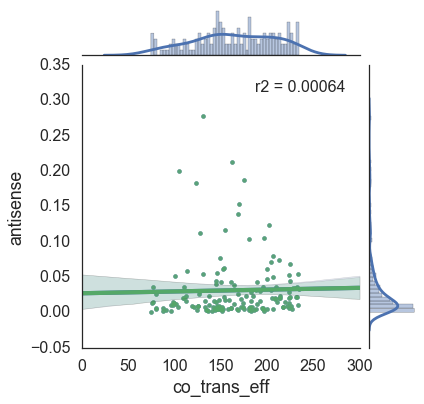

In [25]:
df3=df2[(df2.co_trans_eff> np.percentile(df2.co_trans_eff, 1)) & (df2.co_trans_eff< np.percentile(df2.co_trans_eff,10))]
sns.set(style="white")
from scipy import stats
sns.set_context('poster')
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot(df3.co_trans_eff, df3.antisense, kind="reg", stat_func=r2, marginal_kws=dict(bins=50))
ax = sns.regplot(x="co_trans_eff", y="antisense", data=df3)

# Calculation of 5' and 3' RNA degradation from RNA-seq
1. Calculate coverage at the first 50 bp of each ORF and divide by the coverage of 51 to stop -50
2. The equation is: coverage 1:50/50 ÷ 51:stop-50/length => if value << 1 then there is degradation at the 5' end
3. Calculate coverage athe the last 50 bp of each orf the same logic as above. 

In [32]:
five_prime_cov = []
three_prime_cov = []
middle_cov = []
for index, row in gene_df.iterrows():
    if row['strand']=='plus':
        
        five_prime = fpos[(row['start']):(row['start'])+50].sum()/50
        five_prime_cov.append(five_prime)
        middle = fpos[(row['start']+51):(row['stop']-50)].sum()/ ((row['stop']-50)-row['start']+51)
        middle_cov.append(middle)
        three_prime = fpos[(row['stop']-50):(row['stop'])].sum()/50
        three_prime_cov.append(three_prime)
    elif row['strand']=='minus':
        five_prime = fneg[(row['start']):(row['start'])+50].sum()/50
        five_prime_cov.append(five_prime)
        middle = fneg[(row['start']+51):(row['stop']-50)].sum()/ ((row['stop']-50)-row['start']+51)
        middle_cov.append(middle)
        three_prime = fneg[(row['stop']-50):(row['stop'])].sum()/50
        three_prime_cov.append(three_prime)
gene_df.loc[:,'Fprime_cov']=five_prime_cov
gene_df.loc[:,'middle_cov']=middle_cov
gene_df.loc[:,'Tprime_cov']=three_prime_cov

In [33]:
gene_df.loc[:,'Fprime_ratio']=gene_df['Fprime_cov']/gene_df['middle_cov']
gene_df.loc[:,'Tprime_ratio']=gene_df['Tprime_cov']/gene_df['middle_cov']

In [34]:
    gene_df.replace(to_replace=np.inf, value=np.NaN, inplace=True)

In [35]:
rna_ribo=pd.read_excel('/Users/Max/Dropbox/Clostridium_paper/short_version_percentage_translation.xls')

# Antisense and RNA degradation dataframe

In [36]:
df4 = pd.merge(rna_ribo,gene_df)

In [142]:
df4.columns.values

array([u'gene_id', u'product', u'CO_trans_ave', u'HF_trans_ave',
       u'RNA_ave_CO', u'RNA_ave_HF', u'co_trans_eff', u'hf_trans_eff',
       u'percent_translation_co', u'percent_translation_hf', 'name',
       'function', 'strand', 'start', 'stop', 'cds_seq', 'aaseq',
       'wig_plus', 'wig_minus', 'antisense', 'prime_cov', 'middle_cov',
       '3prime_cov', 'Fprime_cov', 'Tprime_cov', 'Fprime_ratio',
       'Tprime_ratio'], dtype=object)

In [38]:
len(df4)

3100

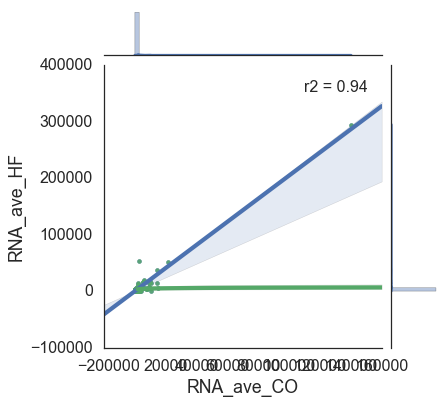

In [39]:
sns.set(style="white")
from scipy import stats
sns.set_context('poster')
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot(df4.RNA_ave_CO, df4.RNA_ave_HF, kind="reg", stat_func=r2, marginal_kws=dict(bins=50))
ax = sns.regplot(x="RNA_ave_CO", y="RNA_ave_HF", data=df4, fit_reg=True, logx=True,)

# Does RNA degradation at the 5 prime end effect translation efficiency?
1. plot co rna-seq vs co ribo-seq
2. plot co rna-seq vs co ribo-seq for a subset of genes that have less than 10th percentile RNA degradation

In [40]:
df5 = df4[df4.antisense <np.percentile(df4.antisense, 10)]
df6 = df4[df4.antisense >np.percentile(df4.antisense,90)]

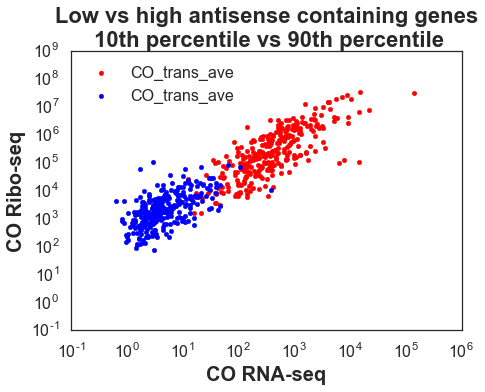

In [41]:
fig,ax = plt.subplots(figsize=(7,5))

plt.scatter(df5.RNA_ave_CO, df5.CO_trans_ave, color='red')
plt.scatter(df6.RNA_ave_CO, df6.CO_trans_ave, color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('CO RNA-seq', fontweight='bold', fontsize=20)
plt.ylabel('CO Ribo-seq', fontweight='bold', fontsize=20)
plt.title('Low vs high antisense containing genes\n 10th percentile vs 90th percentile', fontweight='bold', fontsize=22)
plt.xlim(0.1,1000000)
plt.ylim(0.1,1000000000)
plt.legend(loc=2)
#plt.savefig('/Users/Max/Desktop/hfcutoff.pdf')

In [42]:
df5_1 = df5[['gene_id','CO_trans_ave']]
df6_1 = df6[['gene_id','CO_trans_ave']]
df5_1=df5_1.rename(columns={'CO_trans_ave': 'low anti sense' })
df6_1=df6_1.rename(columns={'CO_trans_ave': 'high anti sense'})
df7= pd.concat([df5_1, df6_1], axis=1)

/Users/Max/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2125: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


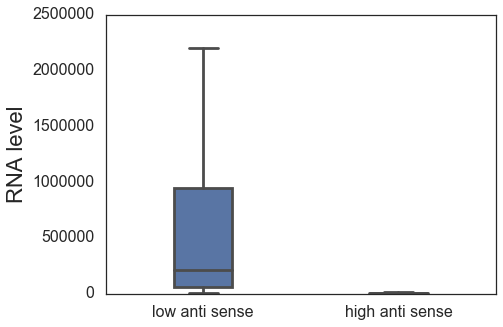

In [43]:
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(7,5))
sns.boxplot(df7, showfliers=False, width=0.3)
plt.ylabel('RNA level', fontsize=22)



It turned out that genes with high antisense have very low RNA levels compared to low antisense. Accordingly, the translational efficiency measure is biased and not valid. 

I will import a subset of translationally inefficient genes and see whether we can find some correlation with antisense or 5prime degradation. 

# Does RNA degradation at the 5 prime end affect translation efficiency?


In [44]:
df5 = df4[df4.Fprime_ratio >np.percentile(df4.Fprime_ratio, 95)] #low degradation
df6 = df4[df4.Fprime_ratio <np.percentile(df4.Fprime_ratio, 5)] # high degradation

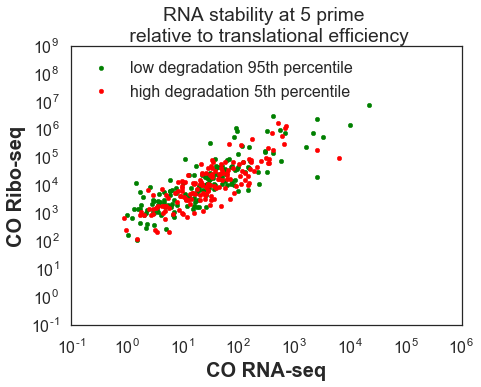

In [45]:
fig,ax = plt.subplots(figsize=(7,5))
plt.scatter(df5.RNA_ave_CO, df5.CO_trans_ave, color='green', label='low degradation 95th percentile')
plt.scatter(df6.RNA_ave_CO, df6.CO_trans_ave, color='red', label='high degradation 5th percentile' )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('CO RNA-seq', fontweight='bold', fontsize=20)
plt.ylabel('CO Ribo-seq', fontweight='bold', fontsize=20)
plt.xlim(0.1,1000000)
plt.ylim(0.1,1000000000)
ax.legend(loc=2)
plt.title('RNA stability at 5 prime \n relative to translational efficiency')

# Does RNA degradation at the 3 prime end affect translation efficiency?



In [46]:
df5 = df4[df4.Tprime_ratio >np.percentile(df4.Tprime_ratio, 95)] #low degradation
df6 = df4[df4.Tprime_ratio <np.percentile(df4.Tprime_ratio, 5)] # high degradation

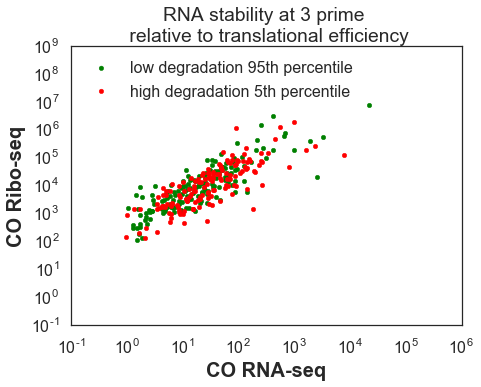

In [47]:
fig,ax = plt.subplots(figsize=(7,5))
plt.scatter(df5.RNA_ave_CO, df5.CO_trans_ave, color='green', label='low degradation 95th percentile')
plt.scatter(df6.RNA_ave_CO, df6.CO_trans_ave, color='red', label='high degradation 5th percentile' )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('CO RNA-seq', fontweight='bold', fontsize=20)
plt.ylabel('CO Ribo-seq', fontweight='bold', fontsize=20)
plt.xlim(0.1,1000000)
plt.ylim(0.1,1000000000)
ax.legend(loc=2)
plt.title('RNA stability at 3 prime \n relative to translational efficiency')

It turned out that mRNA degradation at the 5prime is 

In [48]:
df5 = df4[df4.Fprime_ratio <np.percentile(df4.Fprime_ratio, 5)]
df6 = df4[df4.Fprime_ratio >np.percentile(df4.Fprime_ratio, 95)]
df5_1 = df5[['gene_id','co_trans_eff']]
df6_1 = df6[['gene_id','co_trans_eff']]
df5_1=df5_1.rename(columns={'co_trans_eff': 'high degredation' })
df6_1=df6_1.rename(columns={'co_trans_eff': 'low degradation'})
df7= pd.concat([df5_1, df6_1], axis=1)

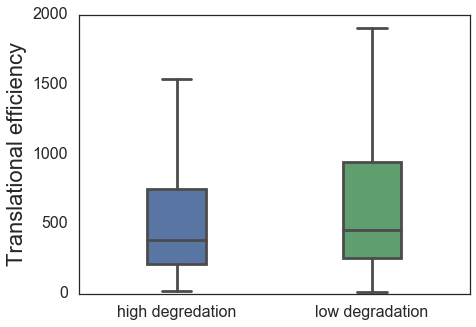

In [49]:
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(7,5))
sns.boxplot(df7, showfliers=False, width=0.3)
plt.ylabel('Translational efficiency', fontsize=22)

# Importing the genes with low and high TE in order to compare their RNA and translation 
### why these genes have low TE?
1. will check RNA degradation
2. will check antisense RNA
3. will check for the presense of sRNA upstream (riboswitch)
4. will check the secondary structure 
5. codon usage

In [179]:
colowte=pd.read_csv('/Users/Max/Dropbox/Clostridium_paper/data_analysis/genes_low_translation_efficiency_CO.txt', sep='\t')
hflowte=pd.read_csv('/Users/Max/Dropbox/Clostridium_paper/data_analysis/genes_low_translation_efficiency_HF.txt', sep='\t')
cohite = pd.read_csv('/Users/Max/Dropbox/Clostridium_paper/data_analysis/genes_high_translation_efficiency_CO.txt',sep='\t')
hfhite= pd.read_csv('/Users/Max/Dropbox/Clostridium_paper/data_analysis/genes_high_translation_efficiency_HF.txt', sep='\t')

In [180]:
colowte=colowte.merge(df4)
cohite=cohite.merge(df4)
hflowte=hflowte.merge(df4)
hfhite=hfhite.merge(df4)

In [181]:
colowte.columns.values

array(['gene_id', 'ec_number', 'product', 'co_rb_mean', 'co_rn_mean',
       'hf_rb_mean', 'hf_rn_mean', 'rescCO', 'index', u'CO_trans_ave',
       u'HF_trans_ave', u'RNA_ave_CO', u'RNA_ave_HF', u'co_trans_eff',
       u'hf_trans_eff', u'percent_translation_co',
       u'percent_translation_hf', 'name', 'function', 'strand', 'start',
       'stop', 'cds_seq', 'aaseq', 'wig_plus', 'wig_minus', 'antisense',
       'prime_cov', 'middle_cov', '3prime_cov', 'Fprime_cov', 'Tprime_cov',
       'Fprime_ratio', 'Tprime_ratio'], dtype=object)

merge dataframes with df4 here! and in the cell below get the antisense and Fprime columns

In [182]:
colowte=colowte[['gene_id', 'co_rb_mean', 'co_rn_mean','Fprime_ratio','antisense'  ]]
cohite=cohite[['gene_id', 'co_rb_mean', 'co_rn_mean', 'Fprime_ratio','antisense']]
hflowte=hflowte[['gene_id','hf_rb_mean','hf_rn_mean', 'Fprime_ratio','antisense' ]]
hfhite=hfhite[['gene_id','hf_rb_mean','hf_rn_mean', 'Fprime_ratio','antisense']]
colowte=colowte.rename(columns={'gene_id':'gene_id','co_rb_mean': 'co_rb_mean_lo', 'co_rn_mean':'co_rn_mean_lo', 'Fprime_ratio':'Fprime_ratio_co_lo','antisense':'antisense_co_lo'})
cohite=cohite.rename(columns={'gene_id':'gene_id','co_rb_mean': 'co_rb_mean_hi', 'co_rn_mean':'co_rn_mean_hi','Fprime_ratio':'Fprime_ratio_co_hi','antisense':'antisense_co_hi'})
hflowte=hflowte.rename(columns={'gene_id':'gene_id','hf_rb_mean': 'hf_rb_mean_lo', 'hf_rn_mean':'hf_rn_mean_lo','Fprime_ratio':'Fprime_ratio_hf_lo','antisense':'antisense_hf_lo' })
hfhite=hfhite.rename(columns={'gene_id':'gene_id','hf_rb_mean': 'hf_rb_mean_hi', 'hf_rn_mean':'hf_rn_mean_hi','Fprime_ratio':'Fprime_ratio_hf_hi','antisense':'antisense_hf_hi' })
colowte.loc[:,'co_te_lo']=colowte.co_rb_mean_lo/colowte.co_rn_mean_lo
cohite.loc[:,'co_te_hi']=cohite.co_rb_mean_hi/cohite.co_rn_mean_hi
hflowte.loc[:,'hf_te_lo']=hflowte.hf_rb_mean_lo/hflowte.hf_rn_mean_lo
hfhite.loc[:,'hf_te_hi']=hfhite.hf_rb_mean_hi/hfhite.hf_rn_mean_hi
colowte=colowte.set_index('gene_id')
cohite=cohite.set_index('gene_id')
hflowte=hflowte.set_index('gene_id')
hfhite=hfhite.set_index('gene_id')


In [547]:
colowte.describe()

,co_rb_mean_lo,co_rn_mean_lo,Fprime_ratio_co_lo,antisense_co_lo,co_te_lo
count,219.000000,219.000000,219.000000,2.190000e+02,219.000000
mean,502.506633,118.807080,1.595181,1.986434e-01,4.702367
std,1117.642929,251.637402,3.784343,1.367588e+00,1.520699
min,3.072299,0.846320,0.029698,1.387636e-09,0.489652
25%,64.119282,12.903328,0.712609,9.030739e-03,3.809537
50%,148.367431,35.437750,1.131584,2.080321e-02,4.748936
75%,365.123956,83.678457,1.620037,5.332140e-02,5.850763
max,10368.293562,2145.525866,55.266241,1.758635e+01,7.226971


In [549]:
np.log2(10368.293562)

13.339890851114358

In [548]:
cohite.describe()

,co_rb_mean_hi,co_rn_mean_hi,Fprime_ratio_co_hi,antisense_co_hi,co_te_hi
count,151.000000,151.000000,151.000000,151.000000,151.000000
mean,57820.555773,290.882755,1.088662,0.067564,228.707239
std,158202.324848,922.163910,0.859980,0.238076,163.805689
min,349.974563,1.076756,0.097262,0.001659,149.286110
25%,1919.479873,10.297222,0.777769,0.008343,165.800267
50%,7468.801788,35.524732,1.001356,0.020163,190.535729
75%,27980.268071,123.470724,1.275914,0.047001,235.792254
max,1213697.403032,8130.008903,10.347716,2.665489,1965.286823


In [161]:
'''colowte=colowte[['gene_id','co_te_lo']]
cohite=cohite[['gene_id','co_te_hi']]
hflowte=hflowte[['gene_id','hf_te_lo']]
hfhite=hfhite[['gene_id','hf_te_hi']]
'''


"colowte=colowte[['gene_id','co_te_lo']]\ncohite=cohite[['gene_id','co_te_hi']]\nhflowte=hflowte[['gene_id','hf_te_lo']]\nhfhite=hfhite[['gene_id','hf_te_hi']]\n"

In [183]:
cohilowcompare= pd.concat([colowte, cohite], axis=1)
hfhilowcompare= pd.concat([hflowte, hfhite], axis=1)

In [184]:
cohilowcompare.head()

,co_rb_mean_lo,co_rn_mean_lo,Fprime_ratio_co_lo,antisense_co_lo,co_te_lo,co_rb_mean_hi,co_rn_mean_hi,Fprime_ratio_co_hi,antisense_co_hi,co_te_hi
CLJU_c00040,148.367431,29.036748,0.968130,0.011504,5.109644,NaN,NaN,NaN,NaN,NaN
CLJU_c00380,74.988489,12.679445,0.764746,0.030325,5.914177,NaN,NaN,NaN,NaN,NaN
CLJU_c00590,125.467273,25.157724,0.870546,0.014303,4.987227,NaN,NaN,NaN,NaN,NaN
CLJU_c00680,NaN,NaN,NaN,NaN,NaN,107107.338235,600.446858,1.115984,0.003041,178.37938
CLJU_c00760,285.781044,61.794108,0.962720,0.003860,4.624730,NaN,NaN,NaN,NaN,NaN


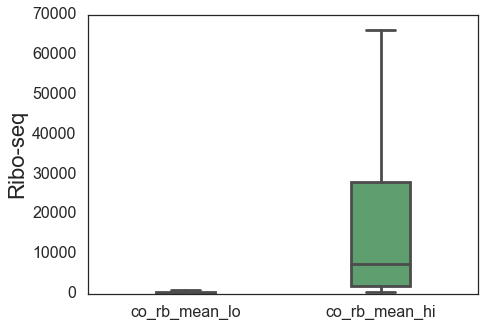

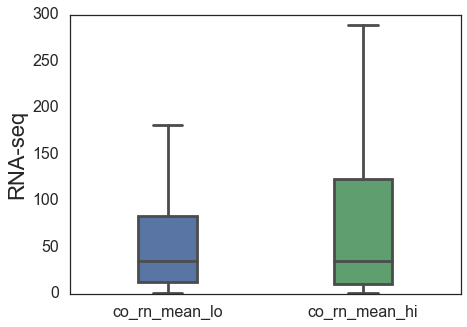

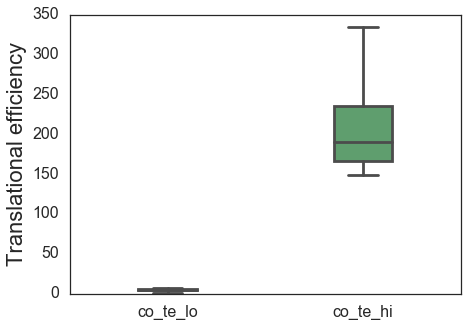

In [541]:
##ribo-seq
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(7,5))
sns.boxplot(cohilowcompare[['co_rb_mean_lo', 'co_rb_mean_hi']], showfliers=False, width=0.3)
plt.ylabel('Ribo-seq', fontsize=22)
##rna-seq
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(7,5))
sns.boxplot(cohilowcompare[['co_rn_mean_lo', 'co_rn_mean_hi']], showfliers=False, width=0.3)
plt.ylabel('RNA-seq', fontsize=22)
##translational efficiency
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(7,5))
sns.boxplot(cohilowcompare[['co_te_lo', 'co_te_hi']], showfliers=False, width=0.3)
plt.ylabel('Translational efficiency', fontsize=22)


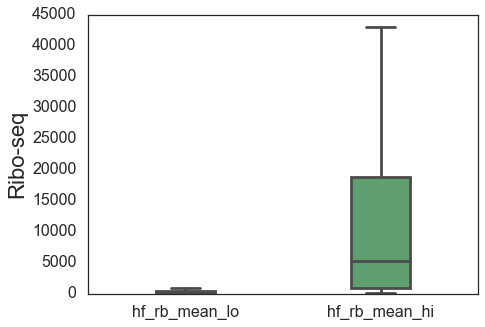

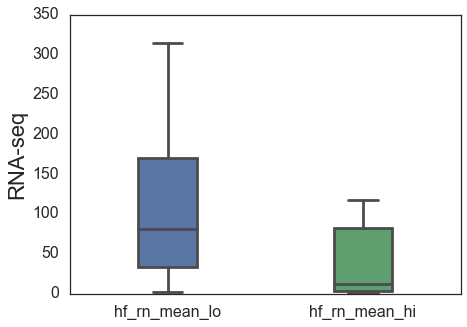

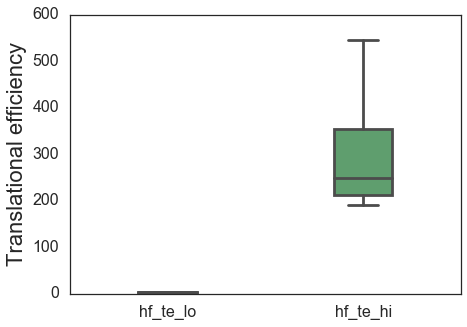

In [187]:
##ribo-seq
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(7,5))
sns.boxplot(hfhilowcompare[['hf_rb_mean_lo', 'hf_rb_mean_hi']], showfliers=False, width=0.3)
plt.ylabel('Ribo-seq', fontsize=22)
##rna-seq
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(7,5))
sns.boxplot(hfhilowcompare[['hf_rn_mean_lo', 'hf_rn_mean_hi']], showfliers=False, width=0.3)
plt.ylabel('RNA-seq', fontsize=22)
##translational efficiency
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(7,5))
sns.boxplot(hfhilowcompare[['hf_te_lo', 'hf_te_hi']], showfliers=False, width=0.3)
plt.ylabel('Translational efficiency', fontsize=22)

In [188]:
cohilowcompare.columns.values

array(['co_rb_mean_lo', 'co_rn_mean_lo', 'Fprime_ratio_co_lo',
       'antisense_co_lo', 'co_te_lo', 'co_rb_mean_hi', 'co_rn_mean_hi',
       'Fprime_ratio_co_hi', 'antisense_co_hi', 'co_te_hi'], dtype=object)

# Antisense

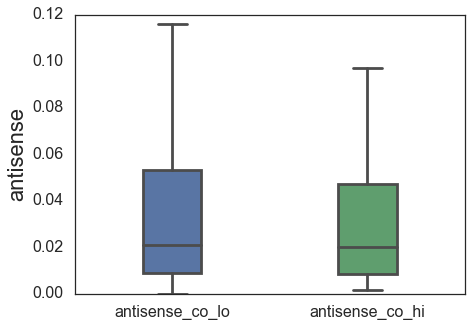

In [192]:

sns.set_context('poster')
fig,ax = plt.subplots(figsize=(7,5))
sns.boxplot(cohilowcompare[['antisense_co_lo', 'antisense_co_hi']], showfliers=False, width=0.3)
plt.ylabel('antisense', fontsize=22)

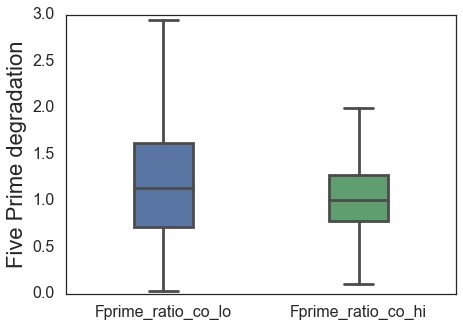

In [193]:

sns.set_context('poster')
fig,ax = plt.subplots(figsize=(7,5))
sns.boxplot(cohilowcompare[['Fprime_ratio_co_lo', 'Fprime_ratio_co_hi']], showfliers=False, width=0.3)
plt.ylabel('Five Prime degradation', fontsize=22)

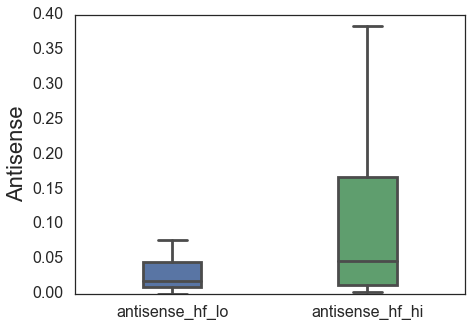

In [197]:
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(7,5))
sns.boxplot(hfhilowcompare[['antisense_hf_lo', 'antisense_hf_hi']], showfliers=False, width=0.3)
plt.ylabel('Antisense', fontsize=22)

# Secondary structure (-∆G) of mRNA and its effect on translation

In [6]:
secstr = pd.read_csv('/home/m/Dropbox/Clostridium_paper/secondary_structure_genes/CLJU_REF_delta_G_not_normalized.txt'\
                     , sep='\t', names=['gene_id', 'dG'])#not normalized by length
norm_secstr=pd.read_csv('/home/m/Dropbox/Clostridium_paper/secondary_structure_genes/CLJU_REF_delta_G_normalized_by_length.txt'\
                       ,sep='\t', names=['gene_id', 'dG'])

In [8]:
secstr=secstr.sort_values(by='gene_id')
norm_secstr=norm_secstr.sort_values(by='gene_id')

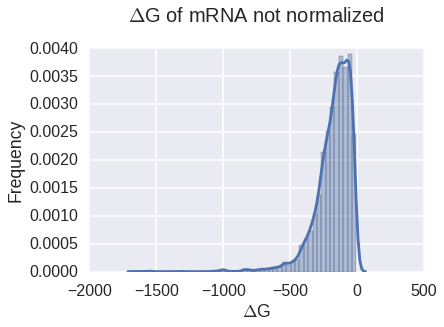

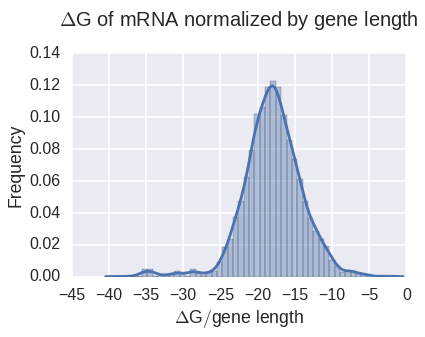

In [11]:
plt.figure(figsize=(6,4))
sns.distplot(secstr.dG, hist=True, bins= 50)
plt.title(r'$\Delta$G ' 'of mRNA not normalized\n', fontsize = 20)
plt.xlabel(r'$\Delta$G')
plt.ylabel('Frequency')

plt.figure(figsize=(6,4))
sns.distplot(norm_secstr.dG, hist=True, bins= 50)
plt.title(r'$\Delta$G ' 'of mRNA normalized by gene length\n', fontsize = 20)
plt.xlabel(r'$\Delta$G' r'$/$' 'gene length')
plt.ylabel('Frequency')

In [519]:
kk=[]
for index, row in secstr.iterrows():
    if row['dG']>np.percentile(secstr.dG, 90):
        kk.append('>90th')
    elif row['dG']<np.percentile(secstr.dG, 10):
        kk.append('<10th')
    elif (row['dG']<np.percentile(secstr.dG, 55)) & (row['dG']>np.percentile(secstr.dG, 45)):
        kk.append('mid')
    else:
        kk.append('other')
secstr['kind']=kk

so ∆G is clearly normally distributed. 
First will check 5 percentile and 95 percentile whether they have clear difference in translational efficiency

In [520]:
secstr=secstr.merge(df4)

In [521]:
large_dG=secstr[secstr.kind=='>90th']
small_dG=secstr[secstr.kind=='<10th']
mid_dG = secstr[secstr.kind=='mid']

In [525]:
len(mid_dG)

310

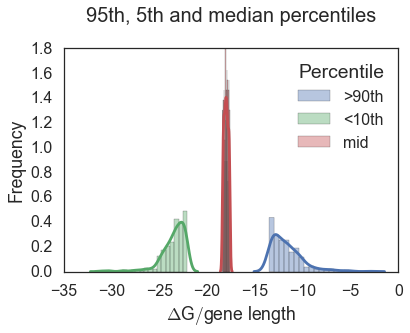

In [526]:
plt.figure(figsize=(6,4))
sns.distplot(large_dG.dG, hist=True, bins=20, label='>90th')
sns.distplot(small_dG.dG, hist=True, bins=20, label='<10th')
sns.distplot(mid_dG.dG, hist=True, bins=20, label = 'mid')
plt.title('95th, 5th and median percentiles\n', fontsize = 20)
plt.xlabel(r'$\Delta$G' r'$/$' 'gene length')
plt.ylabel('Frequency')
plt.legend(title='Percentile')

In [339]:
large_dG.columns.values

array(['gene_id', 'dG', 'index', u'product', u'CO_trans_ave',
       u'HF_trans_ave', u'RNA_ave_CO', u'RNA_ave_HF', u'co_trans_eff',
       u'hf_trans_eff', u'percent_translation_co',
       u'percent_translation_hf', 'name', 'function', 'strand', 'start',
       'stop', 'cds_seq', 'aaseq', 'wig_plus', 'wig_minus', 'antisense',
       'prime_cov', 'middle_cov', '3prime_cov', 'Fprime_cov', 'Tprime_cov',
       'Fprime_ratio', 'Tprime_ratio', 'kind'], dtype=object)

In [527]:
small_large_dG = pd.concat([large_dG, mid_dG, small_dG])

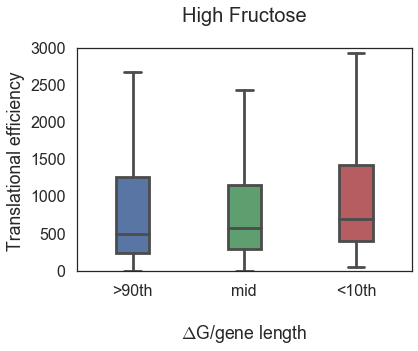

In [538]:
plt.figure(figsize=(6,4))
sns.boxplot(data=small_large_dG, y='hf_trans_eff', x='kind',showfliers=False, width=0.3)
plt.ylabel('Translational efficiency')
plt.title('High Fructose\n', fontsize=20)
plt.ylim(0,3000)
plt.xlabel('\n'r'$\Delta$G/' 'gene length')

In [371]:
import scipy as sp

In [535]:
sp.stats.kruskal(large_dG.hf_trans_eff,mid_dG.hf_trans_eff)

KruskalResult(statistic=0.43097136135361325, pvalue=0.51151270059123721)

In [469]:
len(dfbetween)

619